后25根K线每根的收益率乘其成交量所占比例，得到的加权收益率之和

In [1]:
import polars as pl
import numpy as np

# 假设我们有一个Parquet文件包含交易数据
data = pl.read_parquet("hourly_data.pa")

# 定义时间窗口大小
window_size = 25

# 按照 symbol 和 datetime 排序
df = data.sort(by=["symbol", "open_time"])

# 计算每个小时的收益率
df = df.with_columns([
    (pl.col("close") / pl.col("close").shift(1) - 1).over("symbol").alias("return")
])

# 计算每个symbol的总成交量的滚动窗口和
df = df.with_columns([
    pl.col("volume").rolling_sum(window_size, min_periods=1).over("symbol").alias("rolling_total_volume")
])

# 计算每根K线的收益率乘以其成交量所占比例
df = df.with_columns([
    (pl.col("return") * (pl.col("volume") / pl.col("rolling_total_volume"))).alias("weighted_return")
])

# 计算最近N根K线的加权收益率之和
df = df.with_columns([
    pl.col("weighted_return").rolling_sum(window_size, min_periods=1).over("symbol").alias("weighted_return_sum")
])

# 选择需要的列
result = df.select(["symbol", "open_time", "weighted_return_sum"])

# 打印结果
print(result)



shape: (2_483_434, 3)
┌──────────────┬─────────────────────┬─────────────────────┐
│ symbol       ┆ open_time           ┆ weighted_return_sum │
│ ---          ┆ ---                 ┆ ---                 │
│ str          ┆ datetime[μs]        ┆ f64                 │
╞══════════════╪═════════════════════╪═════════════════════╡
│ 1000LUNCUSDT ┆ 2022-09-09 13:00:00 ┆ null                │
│ 1000LUNCUSDT ┆ 2022-09-09 14:00:00 ┆ 0.007019            │
│ 1000LUNCUSDT ┆ 2022-09-09 15:00:00 ┆ 0.004667            │
│ 1000LUNCUSDT ┆ 2022-09-09 16:00:00 ┆ -0.008602           │
│ 1000LUNCUSDT ┆ 2022-09-09 17:00:00 ┆ -0.0125             │
│ …            ┆ …                   ┆ …                   │
│ ZRXUSDT      ┆ 2022-12-31 19:00:00 ┆ 0.000686            │
│ ZRXUSDT      ┆ 2022-12-31 20:00:00 ┆ 0.000734            │
│ ZRXUSDT      ┆ 2022-12-31 21:00:00 ┆ 0.000683            │
│ ZRXUSDT      ┆ 2022-12-31 22:00:00 ┆ 0.000346            │
│ ZRXUSDT      ┆ 2022-12-31 23:00:00 ┆ 0.000112            │
└─

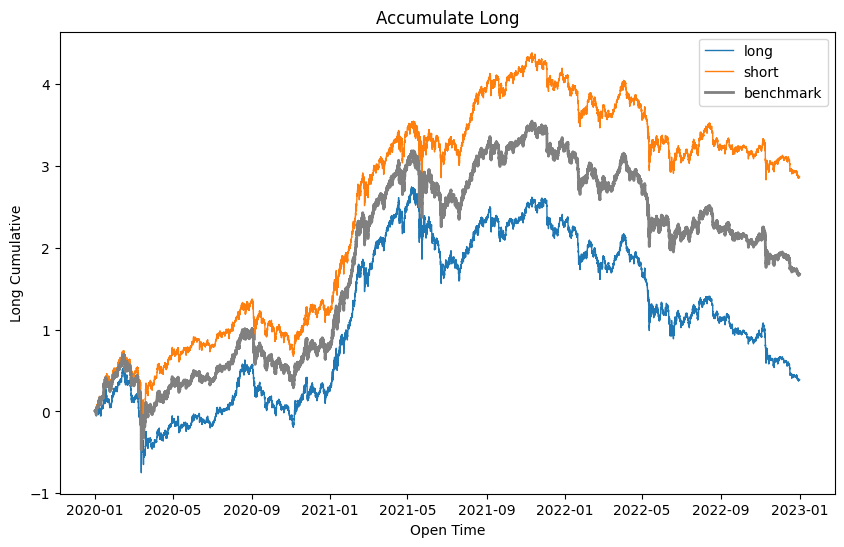

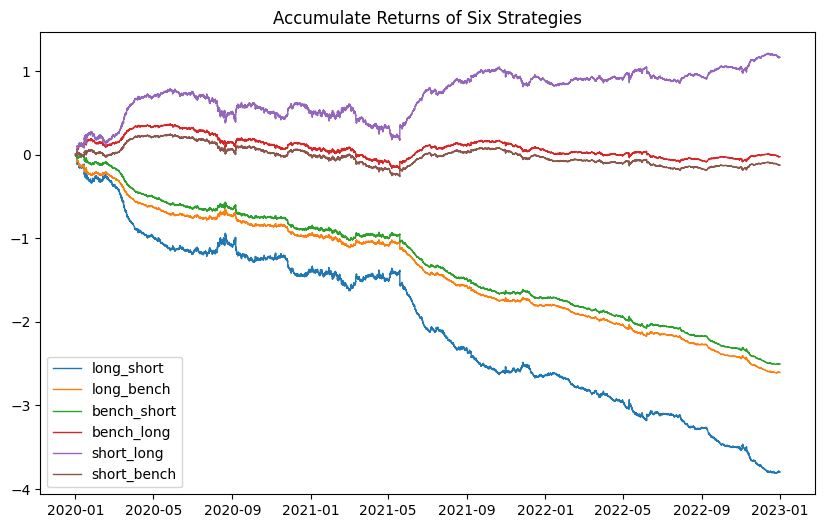

long: 
ann_return = 0.1277  sharpe = 0.1169  maxdd = 0.8367  calmar_ratio = 0.1527  

short: 
ann_return = 0.9537  sharpe = 0.8622  maxdd = 0.608  calmar_ratio = 1.5685  

bench: 
ann_return = 0.5575  sharpe = 0.513  maxdd = 0.6895  calmar_ratio = 0.8085  

long_short: 
ann_return = -1.264  sharpe = -3.8261  maxdd = 3.7784  calmar_ratio = -0.3345  

long_bench: 
ann_return = -0.8678  sharpe = -5.2022  maxdd = 2.6118  calmar_ratio = -0.3323  

bench_long: 
ann_return = -0.0082  sharpe = -0.0493  maxdd = 0.3952  calmar_ratio = -0.0208  

short_long: 
ann_return = 0.388  sharpe = 1.1744  maxdd = 0.3466  calmar_ratio = 1.1193  

short_bench: 
ann_return = -0.0418  sharpe = -0.2529  maxdd = 0.4081  calmar_ratio = -0.1024  

bench_short: 
ann_return = -0.8342  sharpe = -5.0479  maxdd = 2.4912  calmar_ratio = -0.3349  



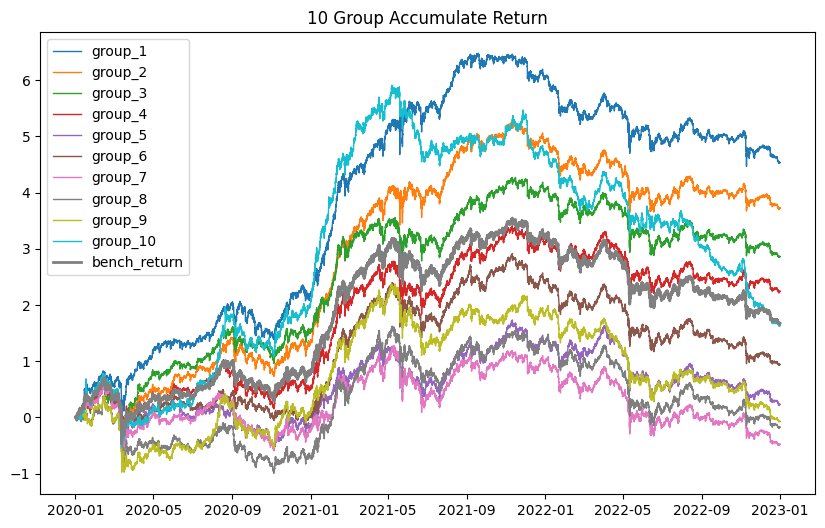

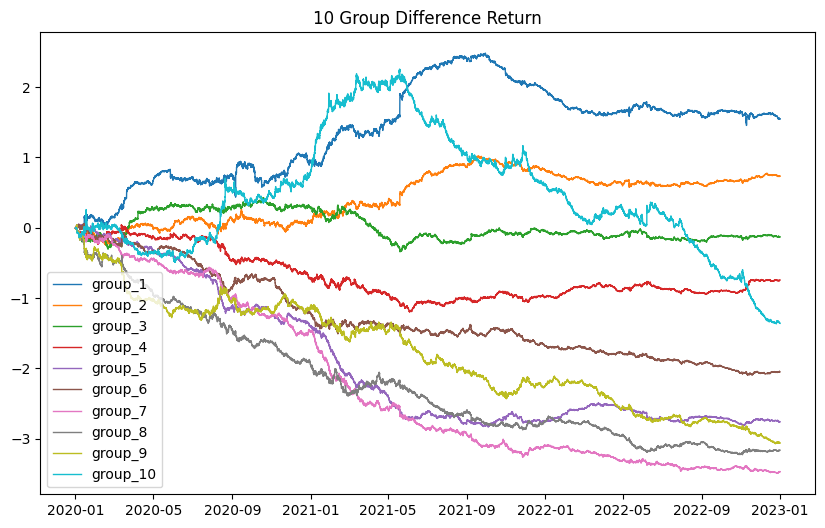

group_1: 
ann_return = 1.5096  sharpe = 1.2044  maxdd = 0.5131  calmar_ratio = 2.9421  

group_2: 
ann_return = 1.2398  sharpe = 1.0799  maxdd = 0.7148  calmar_ratio = 1.7345  

group_3: 
ann_return = 0.9524  sharpe = 0.8581  maxdd = 0.7445  calmar_ratio = 1.2792  

group_4: 
ann_return = 0.7474  sharpe = 0.6837  maxdd = 0.6197  calmar_ratio = 1.206  

group_5: 
ann_return = 0.0766  sharpe = 0.0704  maxdd = 0.7524  calmar_ratio = 0.1018  

group_6: 
ann_return = 0.3126  sharpe = 0.2882  maxdd = 0.7297  calmar_ratio = 0.4284  

group_7: 
ann_return = -0.1598  sharpe = -0.1455  maxdd = 0.8478  calmar_ratio = -0.1885  

group_8: 
ann_return = -0.0578  sharpe = -0.0516  maxdd = 0.9947  calmar_ratio = -0.0581  

group_9: 
ann_return = -0.0239  sharpe = -0.0206  maxdd = 0.9806  calmar_ratio = -0.0244  

group_10: 
ann_return = 0.5425  sharpe = 0.4178  maxdd = 0.7359  calmar_ratio = 0.7373  

-----------------------------------------
group_difference_1: 
ann_return = 0.5141  sharpe = 1.1404  

In [2]:
from factor_analysis.factor_analysis import FactorAnalysis

# 假设 result_df 和 data 已经被读取
analysis = FactorAnalysis(result, data)
analysis.run_full_analysis()